In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#   ..................... MANEJO DEL DATASET .................................

class PlacaDataset(Dataset):

    #   Funcion que carga el dataset

    def __init__(self, X_path, Y_path):
        
        self.X = np.load(X_path).astype(np.float32)
        self.Y = np.load(Y_path).astype(np.float32)

    #   Funcion que devuelve el tamaño que tiene el dataset 

    def __len__(self):
        return len(self.X)
    
    #   Funcion que devuelve el imput o output para cada muestra

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

#   .................... DEFINIDION DEL MODELO ................................

class MLPTempRegressor(nn.Module):

    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(

            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)

        )

    def forward(self, x):
        return self.model(x)

#   .................... CONFIGURACION ...............................................
#   Rutas de archivos 

X_path = 'C:/Users/royer/Documents/ProyectoFinalModelado/data/dataset_5000_test/X.npy'
Y_path = 'C:/Users/royer/Documents/ProyectoFinalModelado/data/dataset_5000_test/Y.npy'

dataset = PlacaDataset(X_path, Y_path)

batch_size = 16 #   Esta es la cantidad de muestras por lote 

#   Se toma 16 muestras del dataset y se las mezlca

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#   Es la cantidad de entradas y salidas del dataset

input_dim = dataset.X.shape[1]
output_dim = dataset.Y.shape[1]

#   Se inicializa el modelo

model = MLPTempRegressor(input_dim, output_dim)

#............................... GPU/CPU ..................................
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
#............................................................................

#..................... DEFINICION DE LA FUNCION DE PERDIDA ..................

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)#    lr es la tasa de aprendizaje. 
epochs = 100   #   Cantidad de iteraciones completas sobre todos los datos 

#............................................................................

#...................... ENTRENAMIENTO ........................................

#   Funcion donde se guarda el historial de perdidas 

loss_history = []

for epoch in range(epochs):

    running_loss = 0.0

    for X_batch, Y_batch in dataloader:

        #   Se transfieren los datos a CPU o GPU
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        optimizer.zero_grad()

        outputs = model(X_batch)

        loss = criterion(outputs, Y_batch)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)

    loss_history.append(avg_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

print("Entrenamiento finalizado.")

Epoch 0, Loss: 1826411.075030
Epoch 10, Loss: 1599485.228322
Epoch 20, Loss: 1538813.268720
Epoch 30, Loss: 1481001.256564
Epoch 40, Loss: 1433391.842452
Epoch 50, Loss: 1374985.895168
Epoch 60, Loss: 1319137.167008
Epoch 70, Loss: 1266153.250012
Epoch 80, Loss: 1220263.344748
Epoch 90, Loss: 1118562.426518
Entrenamiento finalizado.


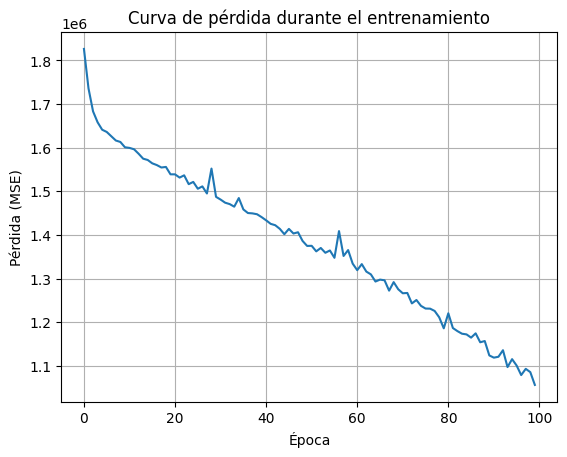

In [26]:
plt.figure()
plt.plot(loss_history)
plt.xlabel("Época")
plt.ylabel("Pérdida (MSE)")
plt.title("Curva de pérdida durante el entrenamiento")
plt.grid()
plt.show()


In [ ]:
model_save_path = 'C:/Users/royer/Documents/ProyectoFinalModelado/results/modelo_temp_ML3.pt'
torch.save(model.state_dict(), model_save_path)
print(f"Modelo guardado en: {model_save_path}")

Modelo guardado en: C:/Users/royer/Documents/ProyectoFinalModelado/results/modelo_temp_ML3.pt


Modelo cargado correctamente.
Comparación de distribuciones:
Diferencia máxima: 498.1530 °C
Diferencia media:  110.2507 °C
Desvío estándar:   99.1035 °C


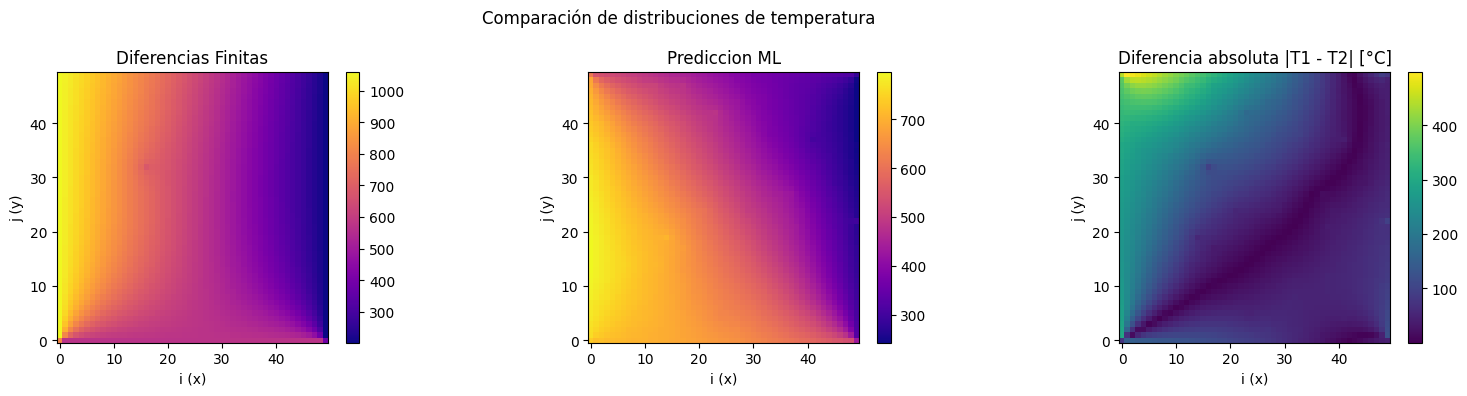

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('C:/Users/royer/Documents/ProyectoFinalModelado/scr')

from utils import graficarChapa, comparar_T


class MLPTempRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        return self.model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_path = 'C:/Users/royer/Documents/ProyectoFinalModelado/data/dataset_5000_test/X.npy'
Y_path = 'C:/Users/royer/Documents/ProyectoFinalModelado/data/dataset_5000_test/Y.npy'

X_data = np.load(X_path).astype(np.float32)
Y_data = np.load(Y_path).astype(np.float32)

input_dim = X_data.shape[1]
output_dim = Y_data.shape[1]

model = MLPTempRegressor(input_dim, output_dim).to(device)
model_save_path = 'C:/Users/royer/Documents/ProyectoFinalModelado/results/modelo_temp_ML3.pt'

model.load_state_dict(torch.load(model_save_path, map_location=device))
model.eval()
print("Modelo cargado correctamente.")

idx_muestra = 4998

X_sample_tensor = torch.tensor(X_data[idx_muestra]).unsqueeze(0).to(device)#   Convierte a un tensor de PyTorch

Y_pred = model(X_sample_tensor).detach().cpu().numpy().reshape(50, 50)  # Ajustar según Nx, Ny

Y_true_reshaped = Y_data[idx_muestra].reshape(50, 50)

comparar_T(Y_true_reshaped, Y_pred, 50, 50, etiquetas=('Diferencias Finitas', 'Prediccion ML'))
